# Introduction

This notebook is dedicated to calculating and predicting the credit risk of someone using the "Status" column as the target variable (or 'y'). The target column is a binary classification where 0 indicates a booking was approved 1 and not approved was 0. The primary goal is to build and evaluate models that can accurately predict whether a somenone would be approved or not by several paramaters (features).

To achieve this, we will deep learning framework that was Feedforward Neural Network that was used by some paramaters:
- **Activation:** Sigmoid (because of the output was binary)
- **Loss:** Binary Crossentropy (used for binary classification problems, where there are only two possible classes)
- **Metrics:** Accuracy (using accuracy of diffrences TP, TN, FN, FT)

Using the deep learning models, the workflow will follow these steps:
- **Load Data:** Import the dataset and perform initial data inspection to understand its structure and contents.
- **Data Preprocessing:** Clean the data by handling missing values, encoding categorical variables, and normalizing numerical features where necessary.
- **PCA:** To reduce dimensions of data features with good number of dimension.
- **Train-Test Split:** Divide the dataset into training and testing sets to evaluate model performance.
- **Model Training:** Train the CatBoost and Random Forest models using the training data.
- **Model Evaluation:** Assess the performance of the trained models using various metrics.
- **Model Tuning:** Optimize model hyperparameters to improve accuracy and other performance metrics.
- **Final Evaluation:** Conduct a final evaluation of the tuned models on the test data.

For evaluating the performance of the models, the following metrics will be used:
- **Accuracy:** The proportion of correctly classified instances out of the total instances.
- **ROC-AUC:** A metric that evaluates the model's ability to distinguish between classes. 
- **F1 Score:** The harmonic mean of precision and recall, which provides a balance between the two.
- **Recall Score:** The ability of the model to correctly identify all relevant instances (i.e., correctly predicting cancellations).
- **Confusion Matrix:** A matrix that provides a detailed breakdown of the model's performance by showing the true positives, true negatives, false positives, and false negatives.

In [1]:
# !nvcc -V && which nvcc

In [2]:
# !python --version
# !nvidia-smi

In [3]:
# !pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com

# Importing Libraries

In [4]:
# importing libraries fundamentals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from matplotlib import pyplot
import plotly.express as px

# Library for Null Values Imputing
import missingno as msno
from sklearn.impute import KNNImputer

# Library for Encoding and Imputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Library for Deep Learning Frameworks
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

2024-07-26 08:35:21.874291: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 08:35:21.874398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 08:35:22.040317: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


# Loading the Dataset

In [6]:
df = pd.read_csv("/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv")

## Dataset Information

In [7]:
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [8]:
df.describe() # description of dataset

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [9]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


(None, (32581, 12))

In [10]:
df.shape
# Dataset has 119390 rows and 32 columns

(32581, 12)

In [11]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [12]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
print(cat_cols)

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')


In [13]:
num_cols = df.select_dtypes(include=['float', 'int64']).columns
print(num_cols)

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length'],
      dtype='object')


## Dealt with Null Values



In [14]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
df[missing_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   person_emp_length  31686 non-null  float64
 1   loan_int_rate      29465 non-null  float64
dtypes: float64(2)
memory usage: 509.2 KB


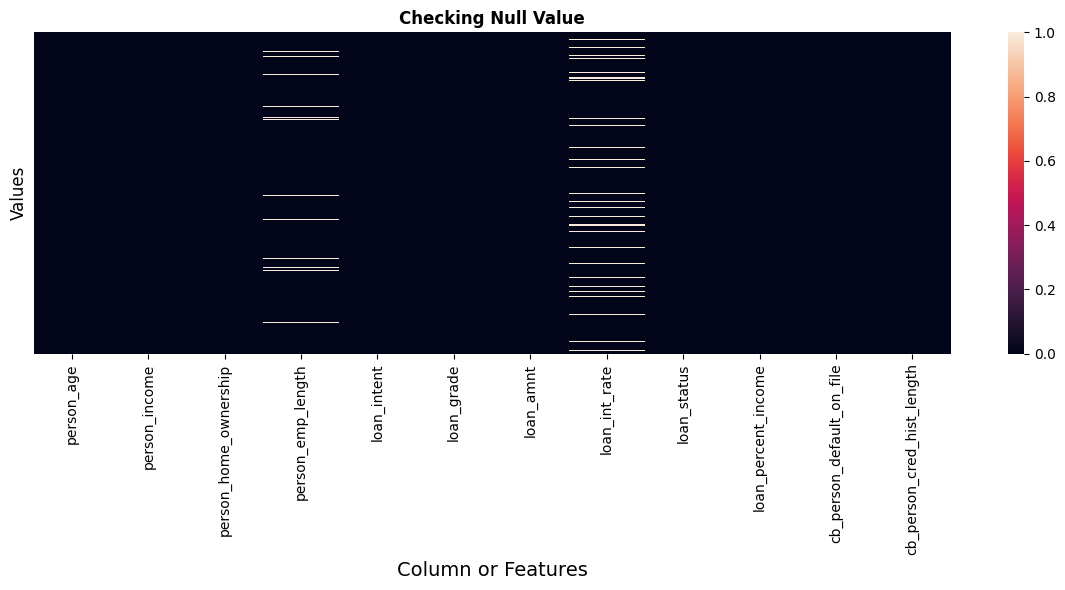

In [15]:
# Plotting Null Values using HeatMap

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), yticklabels=False)
plt.title('Checking Null Value', weight='bold')
plt.xlabel('Column or Features', fontsize=14)
plt.ylabel('Values', fontsize=12)
plt.tight_layout()

In [16]:
def impute_numeric_data(df, columns):
    imputer = KNNImputer(n_neighbors=3)
    imputed_data = pd.DataFrame(imputer.fit_transform(df[columns]), columns=columns)  # Using the provided columns
    df[columns] = imputed_data
    return df

columns_to_impute = ['person_emp_length', 'loan_int_rate']
df = impute_numeric_data(df, columns_to_impute)

In [17]:
missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
df[missing_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Empty DataFrame


# Pearson Feature Elimination (Less Important)

i use this because i run deep learning and perform Val Loss & Train Loss still overfitting.

In [18]:
df_corr = df.copy()
df_corr = df_corr.drop(["loan_status"], axis=1)

In [19]:
def labelencode(df_corr):
    le = LabelEncoder()
    cat_cols = df_corr.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df_corr[col] = le.fit_transform(df_corr[col])
    return df_corr

df_corr = labelencode(df_corr)

In [20]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  int64  
 3   person_emp_length           32581 non-null  float64
 4   loan_intent                 32581 non-null  int64  
 5   loan_grade                  32581 non-null  int64  
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               32581 non-null  float64
 8   loan_percent_income         32581 non-null  float64
 9   cb_person_default_on_file   32581 non-null  int64  
 10  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 2.7 MB


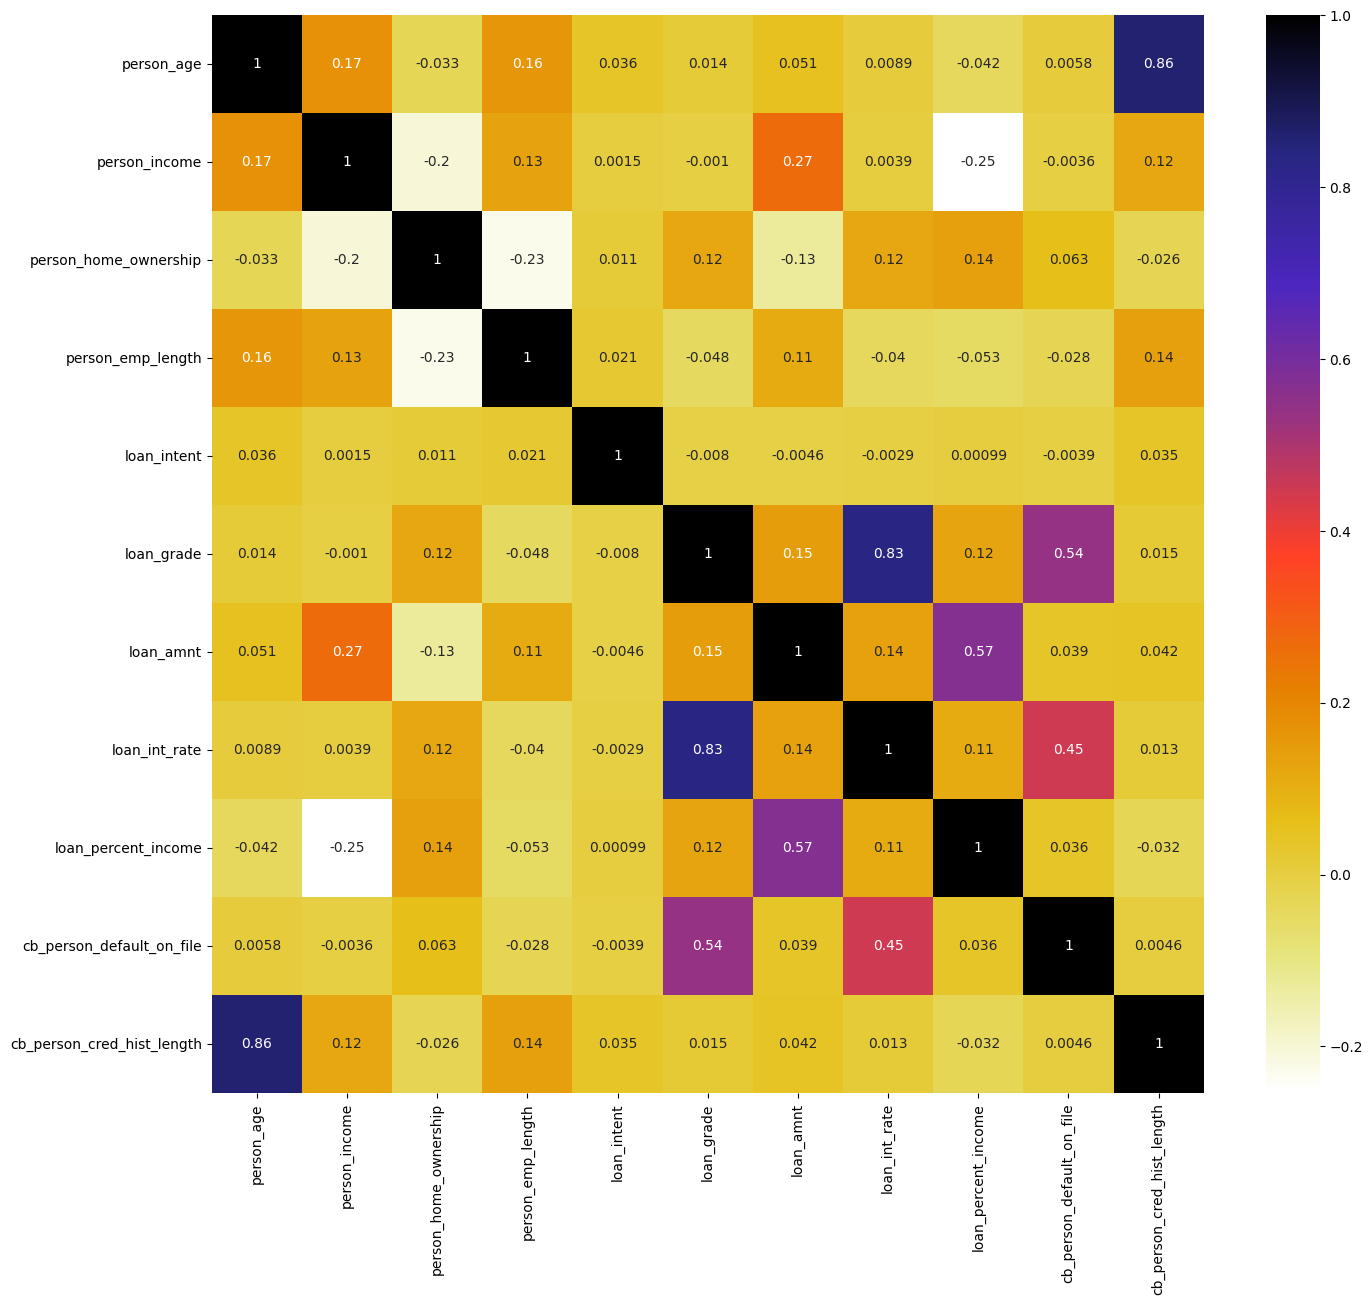

In [21]:
plt.figure(figsize=(16,14))
cor = df_corr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [22]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(df_corr, 0.7)
print(f"Feature should be erased has: {len(set(corr_features))}")
print(f"therefore column should be erased is {corr_features}")

Feature should be erased has: 2
therefore column should be erased is {'cb_person_cred_hist_length', 'loan_int_rate'}


In [23]:
df = df.drop(columns=corr_features)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person_age                 32581 non-null  int64  
 1   person_income              32581 non-null  int64  
 2   person_home_ownership      32581 non-null  object 
 3   person_emp_length          32581 non-null  float64
 4   loan_intent                32581 non-null  object 
 5   loan_grade                 32581 non-null  object 
 6   loan_amnt                  32581 non-null  int64  
 7   loan_status                32581 non-null  int64  
 8   loan_percent_income        32581 non-null  float64
 9   cb_person_default_on_file  32581 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 2.5+ MB


# Split Data

In [24]:
X = df.drop(["loan_status"], axis=1)
y = df["loan_status"]

# Preprocessing (Scaling & Encoding)

In [25]:
list_num_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_percent_income',]
list_cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), list_num_cols),
        ('cat', OneHotEncoder(), list_cat_cols)
    ])


In [26]:
X_transformed = preprocessor.fit_transform(X)

# PCA

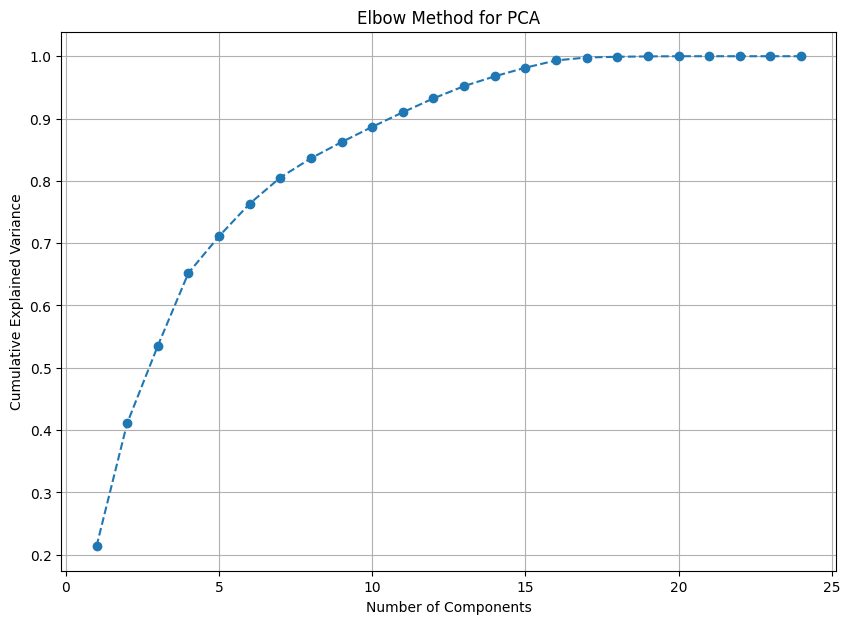

In [27]:
pca = PCA()
pca.fit(X_transformed)

# Calculate explained variance ratio for each number of components
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance ratio
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for PCA')
plt.grid(True)
plt.show()


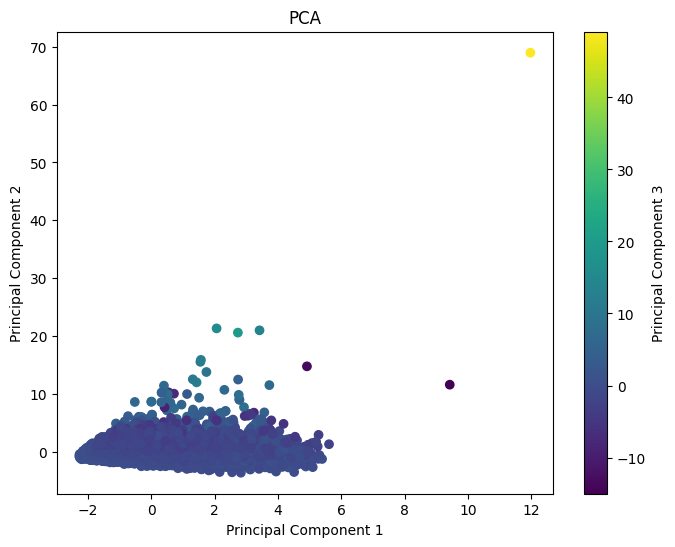

In [28]:
def perform_pca(X_transformed):
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(X_transformed)
    return X_pca

X_pca = perform_pca(X_transformed)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_pca[:, 2])
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Principal Component 3')
plt.show()

# Split Train Test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26064, 5), (6517, 5), (26064,), (6517,))

# Feedforward Neural Network (FNN)

### Build Model

In [31]:
# Learning rate scheduler
def lr_scheduler(epoch, lr):
    decay_rate = 0.96
    decay_step = 10
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)

In [32]:
def build_model_fnn():
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Hidden layers
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid')) # output for binary classification dtype
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model_fnn()

In [33]:
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping, lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
 76/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6821 - loss: 0.6255

I0000 00:00:1721982950.759614     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


652/652 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7804 - loss: 0.4982 - val_accuracy: 0.8316 - val_loss: 0.4073 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8336 - loss: 0.4093 - val_accuracy: 0.8239 - val_loss: 0.4071 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8386 - loss: 0.4013 - val_accuracy: 0.8437 - val_loss: 0.3994 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8449 - loss: 0.3889 - val_accuracy: 0.8391 - val_loss: 0.3946 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8449 - loss:

## Train Loss/Validation Loss (Model Overview)

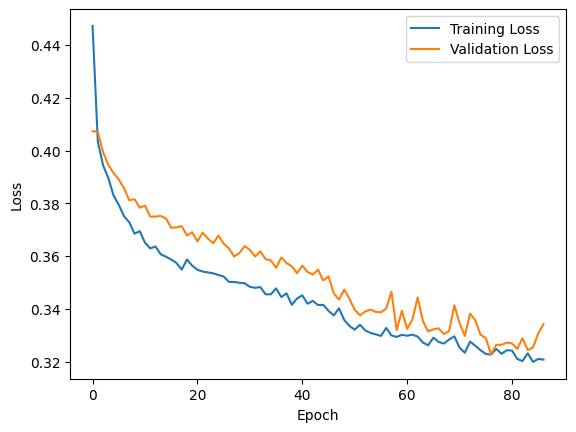

In [34]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
y_pred = (model.predict(X_test) > 0.7).astype("int") # Threshold for Data set up for 0.7 from 1.0
print(classification_report(y_test, y_pred))

roc_auc_model = roc_auc_score(y_test, y_pred)
print(f"ROC AUC score: {roc_auc_model:.2f}")

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      5072
           1       0.95      0.40      0.56      1445

    accuracy                           0.86      6517
   macro avg       0.90      0.70      0.74      6517
weighted avg       0.87      0.86      0.84      6517

ROC AUC score: 0.70


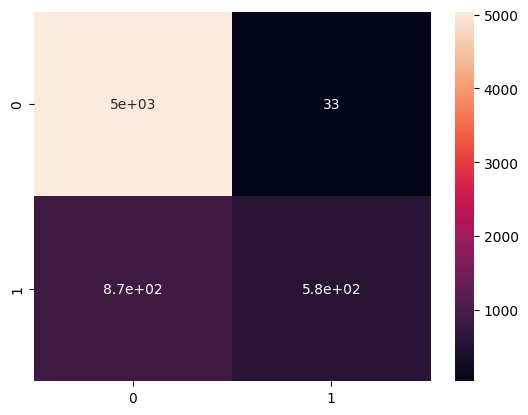

In [36]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True);

# Save the Model

In [37]:
model.save('path/to/model.h5')

# Conclusion :


I think the modelf is good slighltly overfitting, despitely from that we could see the Train Loss/Val Loss indicates the model was good. Therefore, from metrics, the values we got was:

- **Accuracy: 0.70**
- **ROC-AUC: 0.86**